## [익월 최저 항공권 자동 알림 시스템]


- 원래 스카이스캐너를 크롤링 하려 했으나, 다음과 같은 문제로 해결하지 못했습니다.
    - 문제1. 똑같은 코드에서 매번 다른 response를 반환함 (IP, referrer, cookie 의 조합인 것 같다)
        - 이를 해결하려, 서버에서 IP를 바꾸고 cookie, header 등에 계속해서 변화를 줬으나 실패
        
    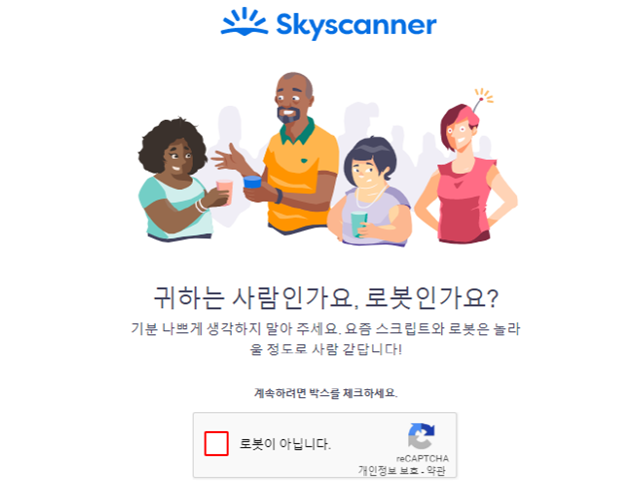
    - 문제2. 쿠키를 전부 삭제하고, 모든 환경을 통일시키고 코드를 실행 -> 완전히 블락
        - 쿠키를 삭제했을 때, Jupyter Note북의 _xrsf missing으로 저장 불가

## 네이버 항공권 크롤링으로 변경
- Javascript와 html이 섞인 구조 : 결제 조건을 click함에 따라 URl이 변경됨 -> Selenium 사용
- 문제1: 일자별로 결제 조건의 개수가 다르다. -> 조건의 길이에 따라 차등 적용

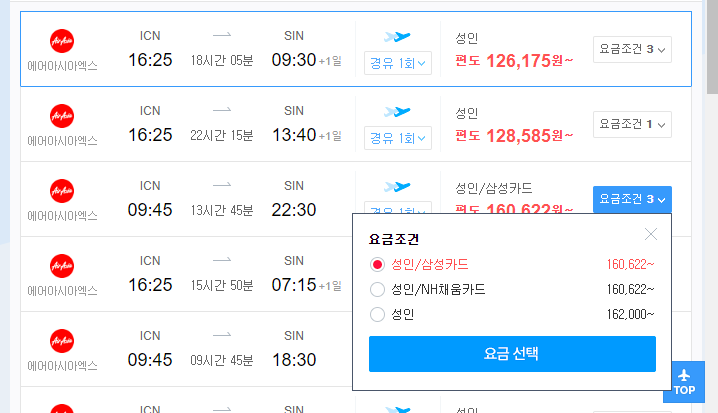

- 문제2: mongoDB 저장? -> 항공권 가격은 시간별, 일별로 변동이 크다. 따라서 저장해봤자 시간이 지나는 순간 무의미한 데이터가 된다.
    - 그래서: 서버의 켜짐과 동시에 크롤링을 시작하고, csv 파일로 계속 overwirte함.

In [11]:
import warnings
warnings.filterwarnings('ignore')

import requests
import time
import pandas as pd
import re
import calendar
import datetime

from bs4 import BeautifulSoup as bs
from PIL import Image as pil
from selenium import webdriver


class naver_flight_ticket():
    
    next_month = datetime.datetime.now().month+1

    def __init__(self, year = 2020, month = next_month, departure = 'SIN'):
        '''
        year(default = 2020)
        month(default = next_month(if today is 2020.03.04 next_month = 4)), 
        departure (IATA Airport Code with Uppercase, default = 'SIN')
        check your IATA code in https://www.asianacargo.com/contents/listOfAirportCode.do
        '''
        self.year = year
        self.month = month
        self.departure = departure
#         dates = []
        
                
        
        
    def get_flight_urls(self):
        '''
        return urls in https://www.flight.naver.com
        from ICN to Destination in specific month
        
        
        '''
        year = self.year
        month = self.month
        departure = self.departure
        
        result = []
        dates = []
#         print(month)
        last_date = calendar.monthrange(year, month)[1]
        urls = []
        
        for date in range(1,last_date+1):
            if len(str(date))==1:
                date='0'+str(date)
            if len(str(month))==1:
                month = '0'+str(month)
            url = 'https://flight.naver.com/flights/v2/results?trip=OW&scity1=ICN&ecity1={}&adult=1&child=0&infant=0&sdate1=\
2020.{}.{}.&fareType=Y'.format(departure,month,date)
            urls.append(url)
        return urls
    
    
    
    
    
    
    def get_flight_info(self):
        data = []
        links = []
        urls = self.get_flight_urls()
        for url in urls:
            print(url[-22:-12])
            options = webdriver.ChromeOptions()
            options.add_argument('headless')
            options.add_argument('window-size=1920x1080')
            driver = webdriver.Chrome(options = options)
            driver.get(url)
            time.sleep(20)

    
            for i in range(5):
                print(i)
                flights = driver.find_elements_by_css_selector('#content > div:nth-child(3) > div.trip_itinerary.ng-scope > div:nth-child(7) > ul > li')
    
                info = flights[i].text.strip().split()
#                 print(info)

                if len(info) == 17:
                    data.append({
                                'date' : url[-22:-12],
                                'airline' : info[0],
                                'departure': info[2],
                                'departure_time' : info[3],
                                'arrival' : info[5],
                                'arrival_time':info[6],
                                'overall_hour':info[9],
                                'price':info[14].replace('원~','')
                        })
                else:
                    data.append({
                                'date' : url[-22:-12],
                                'airline' : info[0],
                                'departure': info[2],
                                'departure_time' : info[3],
                                'arrival' : info[5],
                                'arrival_time':info[6],
                                'overall_hour':info[10],
                                'price':info[15].replace('원~','')
                        })
                num_terms = driver.find_element_by_css_selector('#content > div:nth-child(3) > div.trip_itinerary.ng-scope > div:nth-child(7) > ul > li:nth-child({}) > div:nth-child(5) > a > strong'.format(i+1)).text
                if num_terms != '1':
                    driver.find_element_by_css_selector('#content > div:nth-child(3) > div.trip_itinerary.ng-scope > div:nth-child(7) > ul > li:nth-child({}) > div:nth-child(5) > a'.format(i+1)).click()
                    driver.find_element_by_css_selector('#content > div:nth-child(3) > div.trip_itinerary.ng-scope > div:nth-child(7) > ul > li:nth-child({}) > div:nth-child(5) > div > a.sp_flight.btn_check'.format(i+1)).click()
                    links.append(driver.current_url)
                    driver.find_element_by_css_selector('#content > div:nth-child(2) > div > div > div.trip_title > span').click()
                else:
                    driver.find_element_by_css_selector('#content > div:nth-child(3) > div.trip_itinerary.ng-scope > div:nth-child(7) > ul > li:nth-child({}) > div:nth-child(5) > a'.format(i+1)).click()
                    links.append(driver.current_url)
                    driver.find_element_by_css_selector('#content > div:nth-child(2) > div > div > div.trip_title > span').click()

            driver.quit()
        df = pd.DataFrame(data)
        df['links'] = links
        summary = df[df.price== min(df.price)].sort_values(['date'],ascending = False).reset_index()
        df.to_csv('flight{}.csv'.format(self.month), 'w')
        return df, summary
            

In [13]:
df

,airline,arrival,arrival_time,date,departure,departure_time,overall_hour,price,links
0,에어아시아엑스,SIN,09:30,2020.04.01,ICN,16:25,18시간,"105,905",https://flight.naver.com/flights/v2/results?tr...
1,에어아시아엑스,SIN,18:30,2020.04.01,ICN,09:45,09시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
2,에어아시아엑스,SIN,20:00,2020.04.01,ICN,09:45,11시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
3,에어아시아엑스,SIN,20:45,2020.04.01,ICN,09:45,12시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
4,에어아시아엑스,SIN,08:30,2020.04.01,ICN,16:25,17시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
5,에어아시아엑스,SIN,18:30,2020.04.02,ICN,09:45,09시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
6,에어아시아엑스,SIN,20:00,2020.04.02,ICN,09:45,11시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
7,에어아시아엑스,SIN,20:45,2020.04.02,ICN,09:45,12시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
8,에어아시아엑스,SIN,22:30,2020.04.02,ICN,09:45,13시간,"106,499",https://flight.naver.com/flights/v2/results?tr...
9,에어아시아엑스,SIN,08:30,2020.04.02,ICN,16:25,17시간,"106,499",https://flight.naver.com/flights/v2/results?tr...


In [1]:
import requests
airline, price, date, link = summary.airline[0], summary.price[0], summary.date[0], summary.links[0]
# Api 및 Token 정보
API_HOST = 'https://notify-api.line.me'
headers = {'Authorization': 'Bearer -'}
data = {}


 
# get & post 호출 정의
def req(path, query, method, data={}):
    url = API_HOST + path
 
    print('HTTP Method: %s' % method)
    print('Request URL: %s' % url)
    print('Headers: %s' % headers)
    print('QueryString: %s' % query)
 
    if method == 'GET':
        return requests.get(url, headers=headers)
    else:
        return requests.post(url, headers=headers, data=data)
 
# 메신저로 보낼 메세지 내용
message = '\n'*2 +  '링크: ' + link + '\n'*2+'항공사: '+ airline + '\n' +'가격: '+ '₩'+ price + '\n'+'날짜: ' + date
# imageThumbnail= screenshot_crop.png
# imageFullsize= screenshot_crop.png
 
# parameter 값 및 호출 실행
# params = {"message": message, "imageThumbnail" :imageThumbnail, "imageFullsize" : imageFullsize}
params = {"message": message}
resp = req('/api/notify', '', 'POST', params)
 
# Response
print("response status:\n%d" % resp.status_code)
print("response headers:\n%s" % resp.headers)
print("response body:\n%s" % resp.text)





NameError: name 'summary' is not defined

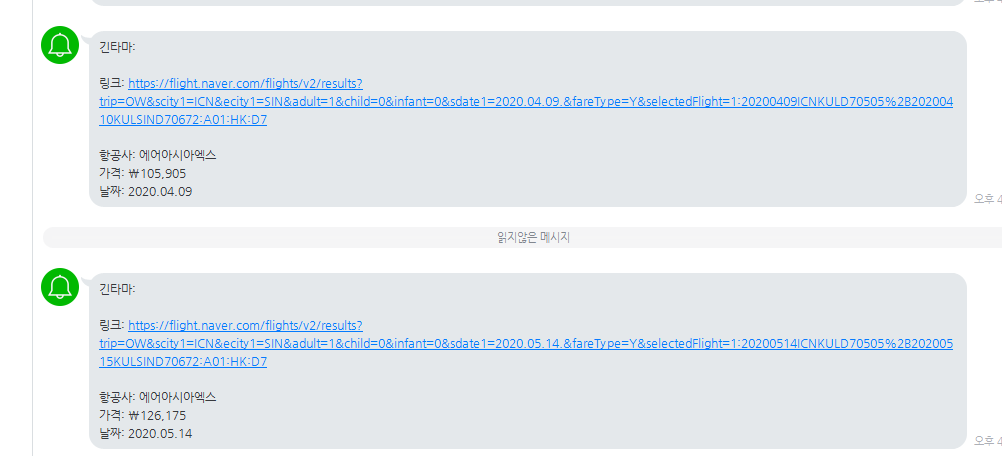
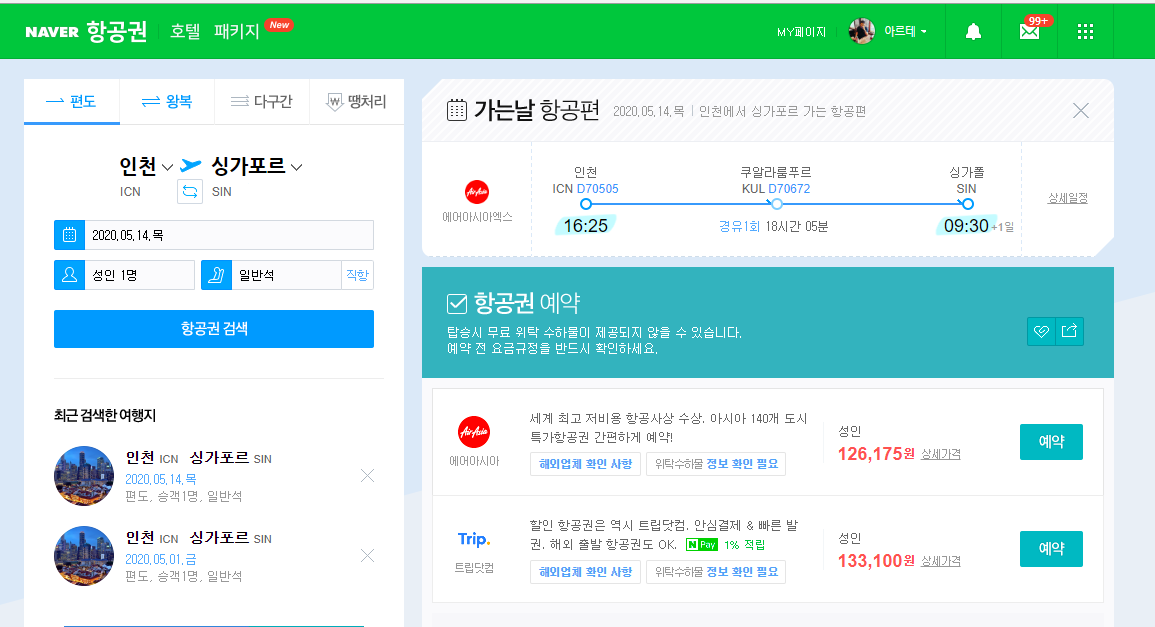

### 과제 & 아쉬운 점
- 셀레니움의 속도: 한달치의 데이터를 가져오는데 약 15분~20분이 걸렸다. (for문이나 다른 조건문에서 속도를 줄일 수 있는 요소 찾아봐야함)
- 다수의 목적지를 정해놓고, 동기간 가격 비교를 구현과 시각화